<div align='center'>

# Basic Scientific Computing

### Part of Scientific-ML-Notes 

[![GitHub](https://img.shields.io/badge/GitHub-Repository-black?logo=github&scale=5)](https://github.com/mhnaderi/Scientific-ML-Notes)

---

In [1]:
# Always run this cell first to import all necessary libraries and to set up the notebook environment

# Import JAX and related libraries
import jax
import jax.numpy as jnp
from jax import grad, jit, hessian, config
from jax.scipy.optimize import minimize as jax_minimize

# Enable 64-bit precision in JAX
config.update("jax_enable_x64", True)

# Import NumPy and SciPy libraries
import numpy as np
import scipy as sp
from scipy.integrate import quad
from scipy.special import roots_legendre
from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint

# Import Matplotlib for plotting
import matplotlib.pyplot as plt

# Configure Matplotlib for inline plotting and LaTeX rendering
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({
    "font.family": "serif",
    "figure.facecolor": 'white', 
    "axes.facecolor": 'white'
})

# Root Finding

Given a function $f: \mathbb{R}^n \rightarrow \mathbb{R}^n$, our goal is to find the vector $\mathbf{x}$ such that $f(\mathbf{x}) = \mathbf{0}$. Such a solution $\mathbf{x}$ is called a root of the equation or a zero of the function $f$. Starting from an initial guess $\mathbf{x}_0$, iterative methods generate a sequence of approximations $\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_k, \ldots$ that, under favorable conditions, converge to a root of the continuous function $f$. Generally, these methods require an initial estimate relatively close to the actual root. To locate multiple roots, one can apply the method using different initial guesses $\mathbf{x}_0$.

Desirable qualities in a root-finding algorithm include:

- **Efficiency**: Requires few function evaluations to converge.
- **Robustness**: Rarely fails; when it does, it provides a meaningful indication of failure.
- **Minimal Requirements**: Does not require extensive additional data, such as derivatives of $f$.
- **Low Smoothness Demands**: Requires only minimal smoothness conditions on $f$.
- **Generality**: Easily extends to systems with multiple equations and unknowns.

## Fixed Point Iteration

Given a function $g: \mathbb{R}^n \rightarrow \mathbb{R}^n$, the fixed point iteration method seeks a root of the equation $f(\mathbf{x}) = \mathbf{x} - g(\mathbf{x}) = \mathbf{0}$. The function $g$ is chosen such that the fixed point of $g$ is the root of $f$. The fixed point iteration method is a simple and widely used technique for root finding.

**Algorithm**:

1. **Initialization**: Choose an initial guess $\mathbf{x}_0$.
2. **Iteration**: For $k = 0, 1, 2, \ldots$, compute
   $$
   \mathbf{x}_{k+1} = g(\mathbf{x}_k)
   $$
   until $\mathbf{x}_{k+1}$ meets the termination criteria.

Fixed point iteration typically exhibits linear convergence, meaning the error decreases by approximately a constant factor $\sigma$ in each iteration.

## Newton's Method

Assuming that $f(\mathbf{x})$ is differentiable and its derivatives are bounded up to at least the second order, we can expand $f$ using a Taylor series around $\mathbf{x}$ for a small displacement $\delta \mathbf{x} \in \mathbb{R}^n$:

$$
f(\mathbf{x} + \delta \mathbf{x}) \approx f(\mathbf{x}) + J(\mathbf{x}) \delta \mathbf{x} + \mathcal{O}(\|\delta \mathbf{x}\|^2)
$$

Here, $J(\mathbf{x})$ is the Jacobian matrix of $f$ at $\mathbf{x}$, defined as:

$$
J(\mathbf{x}) = \begin{pmatrix}
\frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\partial x_2} & \cdots & \frac{\partial f_1}{\partial x_n} \\
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\partial x_2} & \cdots & \frac{\partial f_2}{\partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial f_n}{\partial x_1} & \frac{\partial f_n}{\partial x_2} & \cdots & \frac{\partial f_n}{\partial x_n}
\end{pmatrix}
$$

**Algorithm**:

1. **Initialization**: Set $k = 0$, choose an initial guess $\mathbf{x}_0$.
2. **Iteration**: Until convergence, repeat:
   - Solve the linear system:
     $$
     J(\mathbf{x}_k) \delta \mathbf{x}_k = -f(\mathbf{x}_k)
     $$
     for $\delta \mathbf{x}_k$.
   - Update the solution:
     $$
     \mathbf{x}_{k+1} = \mathbf{x}_k + \delta \mathbf{x}_k
     $$

**Notes**:

- If the Jacobian $J(\mathbf{x})$ is nearly singular, the root is considered ill-conditioned, and the method may struggle.
- Newton's method typically converges quadratically near the root, meaning the number of correct digits roughly doubles with each iteration.
- The computational cost per iteration can be high for large systems:
  - Calculating the Jacobian matrix requires $\mathcal{O}(n^2)$ operations.
  - Solving the linear system typically requires $\mathcal{O}(n^3)$ operations.
- Disadvantages of Newton's method include:
  - The necessity of computing derivatives (Jacobian matrix).
  - Its convergence is local; it requires a good initial guess close to the actual root.

## Secant Method

The secant method modifies Newton's method by approximating the derivative using finite differences, thus avoiding explicit computation of the Jacobian matrix. In the multivariate case, this leads to secant updating methods, such as Broyden's method.

Secant updating methods reduce computational cost by:

- Utilizing function values at successive iterates to approximate the Jacobian, eliminating the need for explicit derivative evaluation.
- Incrementally updating the factorization of the approximate Jacobian, rather than recomputing it entirely at each iteration.
- **Secant methods converge superlinearly**. These methods generally exhibit superlinear convergence, which is faster than linear but not as rapid as quadratic convergence. Although each iteration may be computationally cheaper than Newton's method, the overall number of iterations might be higher.

An alternative approach involves **trust region methods**, where the size of the step $\delta \mathbf{x}$ is constrained within a region where the Taylor series approximation is reliable. By dynamically adjusting the trust region's size, the method can make progress even when starting far from the root, while still achieving rapid convergence near the solution. Unlike damped Newton methods, trust region methods may adjust both the direction and magnitude of the step.

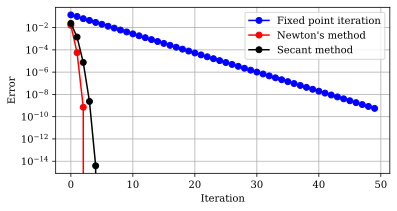

In [2]:
# Define the function for which we want to find the root
f = lambda x: jnp.cos(x) - x

# Initial guess
x0 = 0.5

# Exact root for comparison
exact_root = 0.7390851332151607

# Maximum number of iterations
max_iter = 50

# Lists to store errors for each method
errors_fixed_point, errors_newton, errors_secant = [], [], []

# Fixed point iteration method
x = x0
for i in range(max_iter):
    dx = f(x)
    x += dx
    errors_fixed_point.append(jnp.abs(x - exact_root))

# Newton's method
x = x0
for i in range(max_iter):
    dx = -f(x) / jax.jacobian(f)(x)
    x += dx
    errors_newton.append(jnp.abs(x - exact_root))

# Secant method
x = x0
x_prev = x0 - 0.1  # A small perturbation for the initial previous value
for i in range(max_iter):
    x_new = x - f(x) * (x - x_prev) / (f(x) - f(x_prev))
    errors_secant.append(jnp.abs(x_new - exact_root))
    x_prev = x
    x = x_new

# Plot the errors for each method
plt.figure(figsize=(6, 3), dpi=100)
plt.plot(errors_fixed_point, 'bo-', label="Fixed point iteration")
plt.plot(errors_newton, 'ro-', label="Newton's method")
plt.plot(errors_secant, 'ko-', label="Secant method")
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Optimization

The general continuous optimization problem is formulated as:

$$
\begin{array}{ll}
\underset{\boldsymbol{x}}{\min} & f(\boldsymbol{x}) \\
\text{subject to} & \boldsymbol{g}(\boldsymbol{x}) = \mathbf{0}, \\
& \boldsymbol{h}(\boldsymbol{x}) \leq \mathbf{0}.
\end{array}
$$

Here:

- **Objective Function**: $f: \mathbb{R}^n \rightarrow \mathbb{R}$, a scalar function we aim to minimize.
- **Equality Constraints**: $\boldsymbol{g}: \mathbb{R}^n \rightarrow \mathbb{R}^m$, where $m$ is the number of equality constraints.
- **Inequality Constraints**: $\boldsymbol{h}: \mathbb{R}^n \rightarrow \mathbb{R}^p$, where $p$ is the number of inequality constraints.

In **linear programming**, all functions $f$, $\boldsymbol{g}$, and $\boldsymbol{h}$ are linear. In **nonlinear programming**, at least one of these functions is nonlinear.

## Multimodality and Convexity

Functions can be classified based on the number of local minima they possess; The **Unimodal Functions** have a single minimum, while **Multimodal Functions** have multiple local minima.

### Convex Functions

**Convexity** is a fundamental concept related to the shape of a function and its optimization landscape. A function $f$ is **convex** on a convex set if, for all $\mathbf{x}, \mathbf{y}$ in its domain and any $t \in [0, 1]$, the following inequality holds:

$$
f(t\mathbf{x} + (1 - t)\mathbf{y}) \leq t f(\mathbf{x}) + (1 - t) f(\mathbf{y}).
$$

This property implies that the line segment between any two points on the graph of $f$ lies above the graph itself. Geometrically, convex functions curve upwards, and their epigraphs (the set of points on or above the graph) form a convex set.

- **Convex functions are always unimodal**, possessing a single global minimum.
- Not all unimodal functions are convex; a unimodal function can be non-convex but still have only one minimum.

### Non-Convex Functions

Non-convex functions may exhibit **multiple local minima** (multimodality), making optimization more challenging due to the possibility of getting trapped in local minima.

## Optimality Conditions

In unconstrained optimization, we aim to find a point $\mathbf{x}^*$ where the function $f$ attains a local minimum. A point $\mathbf{x}^*$ is a local minimizer if $f(\mathbf{x}^*) \leq f(\mathbf{x})$ for all $\mathbf{x}$ in a neighborhood around $\mathbf{x}^*$. Essentially, no infinitesimal movement from $\mathbf{x}^*$ results in a decrease in the function value.

To explore the conditions under which $\mathbf{x}^*$ is a local minimum, we examine the Taylor series expansion of $f$ around $\mathbf{x}^*$ for small steps $\mathbf{dx}$:

$$
f(\mathbf{x}^* + \mathbf{dx}) = f(\mathbf{x}^*) + \nabla f(\mathbf{x}^*)^\top \mathbf{dx} + \tfrac{1}{2} \mathbf{dx}^\top H(\mathbf{x}^*) \mathbf{dx} + O(\|\mathbf{dx}\|^3)
$$

Here, $\nabla f(\mathbf{x}^*)$ is the gradient of $f$ at $\mathbf{x}^*$, and $H(\mathbf{x}^*)$ is the Hessian matrix of second derivatives, defined as:

$$
H(\mathbf{x}^*) = \begin{pmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \frac{\partial^2 f}{\partial x_1 \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \\
\frac{\partial^2 f}{\partial x_2 \partial x_1} & \frac{\partial^2 f}{\partial x_2^2} & \cdots & \frac{\partial^2 f}{\partial x_2 \partial x_n} \\
\vdots & \vdots & \ddots & \vdots \\
\frac{\partial^2 f}{\partial x_n \partial x_1} & \frac{\partial^2 f}{\partial x_n \partial x_2} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{pmatrix}
$$

For $\mathbf{x}^*$ to be a local minimizer, the function value at displaced points must be greater than or equal to $f(\mathbf{x}^*)$, i.e., $f(\mathbf{x}^* + \mathbf{dx}) \geq f(\mathbf{x}^*)$ for all small $\mathbf{dx}$.

Substituting the Taylor expansion into this inequality and neglecting the higher-order terms, we obtain:

$$
\nabla f(\mathbf{x}^*)^\top \mathbf{dx} + \tfrac{1}{2} \mathbf{dx}^\top H(\mathbf{x}^*) \mathbf{dx} \geq 0 \quad \text{for all small } \mathbf{dx}
$$

This inequality must hold for every possible $\mathbf{dx}$. Because $\mathbf{dx}$ is infinitesimally small, the linear term $\nabla f(\mathbf{x}^*)^\top \mathbf{dx}$ dominates. To satisfy the inequality for all $\mathbf{dx}$, the linear term must be zero. Otherwise, we could choose $\mathbf{dx}$ in the direction where $\nabla f(\mathbf{x}^*)^\top \mathbf{dx} < 0$, violating the inequality. Therefore, the necessary condition is:

$$
\nabla f(\mathbf{x}^*) = \mathbf{0}
$$

This means that the gradient of $f$ at $\mathbf{x}^*$ must be zero. This is known as the **first-order necessary condition** for optimality.

With the gradient term being zero, the inequality reduces to:

$$
\tfrac{1}{2} \mathbf{dx}^\top H(\mathbf{x}^*) \mathbf{dx} \geq 0 \quad \text{for all } \mathbf{dx}
$$

This condition implies that the Hessian matrix at $\mathbf{x}^*$ must be **positive semidefinite**. A matrix $H$ is positive semidefinite if, for all vectors $\mathbf{dx}$, the quadratic form $\mathbf{dx}^\top H \mathbf{dx} \geq 0$. Thus, the **second-order necessary condition** is:

$$
H(\mathbf{x}^*) \text{ is positive semidefinite}
$$

These two conditions together form the necessary conditions for a local minimum in unconstrained optimization.

However, they are not sufficient. If the Hessian is only positive semidefinite, there might be directions where the curvature is zero ($\mathbf{dx}^\top H(\mathbf{x}^*) \mathbf{dx} = 0$), and we cannot conclude definitively about the nature of $\mathbf{x}^*$ without considering higher-order terms.

For sufficiency, we require that the Hessian be **positive definite**, meaning that:

$$
\mathbf{dx}^\top H(\mathbf{x}^*) \mathbf{dx} > 0 \quad \text{for all non-zero } \mathbf{dx}
$$

This implies that the curvature is strictly positive in all directions, confirming that $\mathbf{x}^*$ is a strict local minimum.

In summary, the **necessary conditions** for a local minimum are:

$$
\begin{aligned}
& \nabla f(\mathbf{x}^*) = \mathbf{0} \\
& H(\mathbf{x}^*) \text{ is positive semidefinite}
\end{aligned}
$$

The **sufficient conditions** are:

$$
\begin{aligned}
& \nabla f(\mathbf{x}^*) = \mathbf{0} \\
& H(\mathbf{x}^*) \text{ is positive definite}
\end{aligned}
$$

Understanding these optimality conditions is crucial in optimization. While analytic solutions using these conditions are possible for some functions, complex or numerically defined functions often require iterative numerical methods that rely on function values and gradients to find minima.

## Line Search Methods

Line search methods are a fundamental class of optimization algorithms that iteratively seek the minimum of a function by performing searches along specific directions. At each iteration, these methods determine a search direction and then perform a one-dimensional optimization, known as a **line search**, to find an optimal step size in that direction. The primary goal of the line search is to identify the step size that minimizes the function value along the chosen direction, thereby updating the current estimate of the solution.

### Steepest Descent Method

One of the most basic gradient-based optimization methods is the **steepest descent** (also known as gradient descent) method. Gradient-based methods are widely used in optimization because they leverage information about the gradient of the objective function to efficiently navigate towards the minimum. The gradient vector at a point indicates the direction of the steepest ascent; therefore, moving in the opposite direction (the negative gradient) leads towards the steepest descent. Gradient-based algorithms generally scale well with the number of variables. 

Let $f: \mathbb{R}^n \rightarrow \mathbb{R}$ be a differentiable real-valued function of $n$ variables. At any point $\boldsymbol{x}$ where the gradient $\nabla f(\boldsymbol{x})$ is non-zero, the negative gradient $-\nabla f(\boldsymbol{x})$ points in the direction of the steepest decrease of the function. This means that, locally, moving in the direction of the negative gradient results in the most rapid decrease in $f$.

Starting from an initial guess $\boldsymbol{x}_0$, the steepest descent method generates a sequence of approximations $\{ \boldsymbol{x}_k \}$ according to:

$$
\boldsymbol{x}_{k+1} = \boldsymbol{x}_k - \alpha_k \nabla f(\boldsymbol{x}_k)
$$

where $\alpha_k > 0$ is the step size, often determined by a line search procedure, that specifies how far to move along the negative gradient direction at iteration $k$.

The steepest descent method is generally reliable in the sense that, as long as the gradient is not zero, it will make progress towards a local minimum. However, because it only considers local information and moves in the direction of the immediate steepest decrease, it can be shortsighted in terms of the overall landscape of the function. This can lead to inefficient zigzagging, especially in narrow valleys or elongated regions of the function's contour lines, resulting in slow convergence.

In practice, the **convergence rate of the steepest descent method is linear**, meaning that the error decreases proportionally at each iteration by a constant factor. Unfortunately, this constant can be close to 1, especially for ill-conditioned problems, leading to very slow convergence.

#### Example: Minimizing the Rosenbrock Function

To illustrate optimization techniques, let's explore the minimization of the **Rosenbrock function**, a classic test case in optimization algorithms. For a system of $N$ variables, the Rosenbrock function is defined as:

$$
f(\mathbf{x}) = \sum_{i=1}^{N-1} \left[ 100 \left( x_{i+1} - x_i^2 \right )^2 + \left( 1 - x_i \right )^2 \right]
$$

This function reaches its global minimum value of zero when all components of the vector $\mathbf{x}$ are equal to one:

$$
\mathbf{x}^* = [1, 1, \ldots, 1]
$$

That is, $x_i = 1$ for all $i = 1, 2, \ldots, N$.

The Rosenbrock function is notorious for its narrow, curved valley leading to the minimum, which makes it challenging for optimization algorithms to find the global minimum efficiently. It serves as a useful benchmark for evaluating the performance and robustness of different optimization methods.

In [3]:
# Parameters for the Rosenbrock function
a, b = 100.0, 0.0

# Learning rate for gradient descent
alpha = 0.001

# Define the Rosenbrock function
rosen = jit(lambda x: jnp.sum(a * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0) + b)

# Compute the gradient of the Rosenbrock function
grad_rosen = jit(grad(rosen))

# Initial guess for the variables
x = jnp.array([1.3, 0.7, 0.8, 1.9, 1.2])

# Gradient descent loop
for i in range(10000):
    x -= alpha * grad_rosen(x)
    
    # Print the progress every 1000 iterations
    if i % 1000 == 0:
        print(f"iteration {i:5d}, x = {x}, f(x) = {rosen(x)}")

# Print the final result
print(f"Minimum found at x = {x}")

iteration     0, x = [ 0.7846  0.9854  1.1416 -0.1854  1.682 ], f(x) = 511.13270445299486
iteration  1000, x = [0.96531308 0.93172724 0.86784982 0.75256    0.56492605], f(x) = 0.08480086705679753
iteration  2000, x = [0.98340303 0.96702467 0.93499197 0.8738955  0.76301367], f(x) = 0.021549724576402425
iteration  3000, x = [0.99098165 0.98201227 0.96426634 0.92963465 0.86385382], f(x) = 0.006650350099327803
iteration  4000, x = [0.99483705 0.98968185 0.97942256 0.95916743 0.91979322], f(x) = 0.002229500393544348
iteration  5000, x = [0.99696618 0.99393033 0.98786928 0.97582603 0.95211404], f(x) = 0.0007795269399015858
iteration  6000, x = [0.99819175 0.99638003 0.99275627 0.98552935 0.97119528], f(x) = 0.00027893583314382553
iteration  7000, x = [0.99891343 0.99782399 0.99564253 0.99128259 0.98259747], f(x) = 0.00010114552573272876
iteration  8000, x = [0.99934397 0.99868592 0.99736741 0.99472879 0.98945899], f(x) = 3.696409632223343e-05
iteration  9000, x = [0.99960279 0.99920426 0.998

### Newton's Method

To gain a deeper insight into the function's behavior near a minimum, we can utilize a local quadratic approximation of the objective function. This approach leads us to **Newton's method** for optimization. In multidimensional optimization, our goal is to find the point where the gradient of the function vanishes—that is, we seek a solution to $\nabla f(\boldsymbol{x}) = \mathbf{0}$.

Newton's method iteratively updates the estimate of the minimum by solving for the Newton step $\delta \boldsymbol{x}_k$ at each iteration $k$:

$$
H_f(\boldsymbol{x}_k) \, \delta \boldsymbol{x}_k = -\nabla f(\boldsymbol{x}_k)
$$

Here:

- $H_f(\boldsymbol{x}_k)$ is the **Hessian matrix** of second-order partial derivatives of the function $f$ evaluated at the current point $\boldsymbol{x}_k$.
- $\nabla f(\boldsymbol{x}_k)$ is the **gradient vector** of the function at $\boldsymbol{x}_k$.

After computing the Newton step $\delta \boldsymbol{x}_k$, we update the next iterate as:

$$
\boldsymbol{x}_{k+1} = \boldsymbol{x}_k + \delta \boldsymbol{x}_k
$$

**Convergence Rate**:

- **Quadratic Convergence**: Newton's method typically exhibits quadratic convergence near the solution. This means that the error decreases exponentially with each iteration—the number of correct digits roughly doubles each time.
- **Dependence on Initial Guess**: Despite its fast convergence near the minimum, Newton's method can be unreliable if the initial guess $\boldsymbol{x}_0$ is not sufficiently close to the true solution. Far from the minimum, the quadratic approximation may be poor, leading to divergence or convergence to an unintended local minimum.

In [4]:
# Parameters for the Rosenbrock function
a, b = 100.0, 0.0

# Define the Rosenbrock function
rosen = jit(lambda x: jnp.sum(a * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0) + b)

# Compute the gradient of the Rosenbrock function
grad_rosen = jit(grad(rosen))

# Compute the Hessian of the Rosenbrock function
hess_rosen = jit(hessian(rosen))

# Initial guess for the variables
x = jnp.array([1.3, 0.7, 0.8, 1.9, 1.2])

# Newton's method loop
for i in range(100):
    # Update x using Newton's method
    x += jnp.linalg.solve(hess_rosen(x), -grad_rosen(x))
    
    # Print the progress every 10 iterations
    if i % 10 == 0:
        print(f"iteration {i:5d}, x = {x}, f(x) = {rosen(x)}")

# Print the final result
print(f"Minimum found at x = {x}")

iteration     0, x = [ 0.31729926 -1.61601211 -2.2818618   0.83653878 -0.43115262], f(x) = 4745.208509455058
iteration    10, x = [0.88887992 0.78952024 0.62199557 0.38221818 0.13469582], f(x) = 0.5965632186701729
iteration    20, x = [1. 1. 1. 1. 1.], f(x) = 0.0
iteration    30, x = [1. 1. 1. 1. 1.], f(x) = 0.0
iteration    40, x = [1. 1. 1. 1. 1.], f(x) = 0.0
iteration    50, x = [1. 1. 1. 1. 1.], f(x) = 0.0
iteration    60, x = [1. 1. 1. 1. 1.], f(x) = 0.0
iteration    70, x = [1. 1. 1. 1. 1.], f(x) = 0.0
iteration    80, x = [1. 1. 1. 1. 1.], f(x) = 0.0
iteration    90, x = [1. 1. 1. 1. 1.], f(x) = 0.0
Minimum found at x = [1. 1. 1. 1. 1.]


### Secant Updating Methods

While methods like **Broyden's method** can be used to find the zero of the gradient (i.e., solve $\nabla f(\mathbf{x}) = \mathbf{0}$), they do not preserve the symmetry of the Hessian matrix approximation. In optimization, maintaining the symmetry and positive definiteness of the approximate Hessian is important for both computational efficiency and convergence reliability.

Several **secant updating methods** have been developed specifically for optimization that not only preserve the symmetry of the approximate Hessian matrix but also ensure its positive definiteness. Symmetry reduces the computational workload by approximately half, as only the upper or lower triangular portion of the matrix needs to be stored and updated. Positive definiteness guarantees that the search direction is a descent direction, which is critical for the convergence of the algorithm.

One of the most effective and widely used secant updating methods for minimization is the **Broyden-Fletcher-Goldfarb-Shanno (BFGS)** algorithm.

Key features of the BFGS method include:

- **Efficient Computations**: Instead of updating the approximate Hessian matrix $\mathbf{H}_k$ directly, the BFGS method updates its inverse or maintains a factorization of it. This approach allows the search direction $\mathbf{p}_k$ to be computed efficiently by solving the linear system:
  $$
  \mathbf{H}_k \mathbf{p}_k = -\nabla f(\mathbf{x}_k)
  $$
  Because $\mathbf{H}_k$ is symmetric and positive definite, solving for $\mathbf{p}_k$ can be done in $\mathcal{O}(n^2)$ operations using methods like Cholesky decomposition, instead of the $\mathcal{O}(n^3)$ operations required for a general matrix inversion.

- **Avoidance of Second Derivatives**: Unlike Newton's method, which requires the computation of the Hessian matrix (second derivatives), the BFGS algorithm builds up an approximation of the inverse Hessian using only gradient evaluations and differences in successive iterates. This makes BFGS suitable for problems where computing second derivatives is difficult or computationally expensive.

- **Initialization and Progressive Improvement**: The algorithm typically starts with an initial approximation of the inverse Hessian, often chosen as the identity matrix $\mathbf{H}_0 = \mathbf{I}$. This means the first search direction is equivalent to the negative gradient, similar to the steepest descent method. As iterations progress, the approximation of the inverse Hessian improves, incorporating curvature information gleaned from the observed changes in gradients and iterates.

- **Superlinear Convergence Rate**: The BFGS method generally exhibits a superlinear convergence rate. This efficient convergence is achieved even though the approximate Hessian matrix does not necessarily converge to the true Hessian of the function. The method effectively captures enough curvature information to accelerate convergence compared to first-order methods.

- **Integration with Line Search**: Incorporating a **line search** strategy enhances the effectiveness of the BFGS method. The line search determines an appropriate step size $\alpha_k$ at each iteration to ensure sufficient decrease in the objective function and to maintain the positive definiteness of the updated Hessian approximation. This integration is crucial for the robustness and efficiency of the algorithm.

In [5]:
# Parameters for the Rosenbrock function
a, b = 100.0, 0.0

# Define the Rosenbrock function
rosen = jit(lambda x: jnp.sum(a * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0) + b)

# Initial guess for the variables
x = jnp.array([1.3, 0.7, 0.8, 1.9, 1.2])

# Minimize the Rosenbrock function using BFGS method
result = jax_minimize(rosen, x, method='BFGS')

# Print the final result
print(f"Minimum found at x = {result.x}")

Minimum found at x = [0.99673969 0.99450075 0.98856497 0.97546818 0.9507831 ]


### Conjugate Gradient Method

Another optimization technique that avoids explicit computation of second derivatives and does not require storing an approximation of the Hessian matrix is the **Conjugate Gradient (CG) method**. The CG method generates a sequence of conjugate (mutually orthogonal with respect to the Hessian) search directions, effectively accumulating information about the Hessian implicitly through these directions.

For a quadratic objective function of the form:

$$
f(\boldsymbol{x}) = \tfrac{1}{2} \boldsymbol{x}^\top \boldsymbol{A} \boldsymbol{x} - \boldsymbol{b}^\top \boldsymbol{x} + c,
$$

where $\boldsymbol{A}$ is a symmetric positive-definite matrix, the Conjugate Gradient method is theoretically guaranteed to find the exact solution in at most $n$ iterations, with $n$ being the dimension of the problem. Each iteration computes a search direction that is conjugate with respect to $\boldsymbol{A}$ to all previous search directions, ensuring efficient progress toward the minimum.

The CG method is effective not only for quadratic functions but also for general unconstrained minimization problems. In these cases, while the exact solution may not be reached in $n$ iterations, the method still benefits from the efficient exploration of the search space without the need to compute or store the Hessian matrix.

**Key Features of the Conjugate Gradient Method**:

- **No Explicit Hessian Required**: The method bypasses the need for second derivative calculations and Hessian storage, making it suitable for large-scale problems.
  
- **Implicit Hessian Information**: By generating conjugate directions, the method implicitly gathers curvature information about the objective function.
  
- **Efficiency for Quadratic Functions**: For quadratic objectives, the method converges to the exact solution in at most $n$ iterations.
  
- **Applicability to General Problems**: The CG method is effective for general unconstrained optimization problems, offering a good balance between convergence speed and computational resource requirements.

In [6]:
# Parameters for the Rosenbrock function
a, b = 100.0, 0.0

# Define the Rosenbrock function
rosen = jit(lambda x: jnp.sum(a * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0) + b)

# Compute the gradient of the Rosenbrock function
grad_rosen = jit(grad(rosen))

# Compute the Hessian of the Rosenbrock function
hess_rosen = jit(hessian(rosen))

# Initial guess for the variables
x0 = jnp.array([1.3, 0.7, 0.8, 1.9, 1.2])

# Minimize the Rosenbrock function using Newton-CG method
res = minimize(rosen, x0, method='Newton-CG', jac=grad_rosen, hess=hess_rosen, options={'xtol': 1e-8, 'disp': True})

# Print the final result
print(f"Minimum found at x = {res.x}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 33
         Gradient evaluations: 33
         Hessian evaluations: 24
Minimum found at x = [1.         1.         1.         0.99999999 0.99999999]


## Trust Region Methods

Trust region methods offer an alternative approach to line search methods for optimization. Instead of first determining a search direction and then finding an appropriate step size, trust region methods operate by:

1. Establishing a region around the current point where we "trust" a quadratic approximation of the objective function to be accurate
2. Finding the optimal step within this trusted region

The method solves a constrained quadratic subproblem at each iteration:

$$
\begin{aligned}
\min_{\mathbf{dx}} \quad & f(\mathbf{x}_k) + \nabla f(\mathbf{x}_k)^\top \mathbf{dx} + \frac{1}{2}\mathbf{dx}^\top H(\mathbf{x}_k)\mathbf{dx} \\
\text{subject to} \quad & \|\mathbf{dx}\| \leq \Delta
\end{aligned}
$$

where:
- $\mathbf{x}_k$ is the current iterate
- $\Delta$ is the trust region radius
- $\nabla f(\mathbf{x}_k)$ is the gradient at $\mathbf{x}_k$
- $H(\mathbf{x}_k)$ is the Hessian (or an approximation) at $\mathbf{x}_k$

**Key Features**:

1. **Adaptive Trust Region**: The radius $\Delta$ is dynamically adjusted based on how well the quadratic model predicts the actual function behavior:
   - If the model predictions are accurate, $\Delta$ may be increased
   - If predictions are poor, $\Delta$ is reduced

2. **Update Process**:
   - Solve the constrained quadratic subproblem for step $\mathbf{dx}$
   - Update the solution: $\mathbf{x}_{k+1} = \mathbf{x}_k + \mathbf{dx}$
   - Adjust trust region radius based on model performance

3. **Advantages**:
   - More robust than line search methods, especially far from the solution
   - Can handle non-convex problems more effectively
   - Naturally adapts step size based on model accuracy
   - Can modify both direction and length of the step

Trust region methods are particularly effective when dealing with ill-conditioned problems or when far from the solution, where line search methods might struggle.

In [7]:
# Parameters for the Rosenbrock function
a, b = 100.0, 0.0

# Define the Rosenbrock function
rosen = jit(lambda x: jnp.sum(a * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0) + b)

# Compute the gradient of the Rosenbrock function
grad_rosen = jit(grad(rosen))

# Compute the Hessian of the Rosenbrock function
hess_rosen = jit(hessian(rosen))

# Initial guess for the variables
x0 = jnp.array([1.3, 0.7, 0.8, 1.9, 1.2])

# Minimize the Rosenbrock function using trust-ncg method
res = minimize(rosen, x0, method='trust-ncg', jac=grad_rosen, hess=hess_rosen, options={'gtol': 1e-8, 'disp': True})

# Print the final result
print(f"Minimum found at x = {res.x}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 20
         Hessian evaluations: 19
Minimum found at x = [1. 1. 1. 1. 1.]


## Constrained Optimization

### Equality-Constrained Optimization

In many practical applications, optimization problems come with constraints that must be satisfied. For equality-constrained optimization problems, we seek to:

$$
\begin{array}{ll}
\underset{\boldsymbol{x}}{\min} & f(\boldsymbol{x}) \\
\text{subject to} & \boldsymbol{g}(\boldsymbol{x}) = \mathbf{0}
\end{array}
$$

where:
- $f: \mathbb{R}^n \rightarrow \mathbb{R}$ is the objective function
- $\boldsymbol{g}: \mathbb{R}^n \rightarrow \mathbb{R}^m$ represents $m$ equality constraints
- $m \leq n$ ensures the problem is not over-constrained

**The Lagrangian Approach**:

We form the Lagrangian function by introducing Lagrange multipliers $\boldsymbol{\lambda}$:

$$
\mathcal{L}(\boldsymbol{x}, \boldsymbol{\lambda}) = f(\boldsymbol{x}) + \boldsymbol{\lambda}^\top \boldsymbol{g}(\boldsymbol{x})
$$

The necessary conditions for optimality require finding critical points of the Lagrangian, leading to the system:

$$
\nabla \mathcal{L}(\boldsymbol{x}, \boldsymbol{\lambda}) = \begin{bmatrix}
\nabla f(\boldsymbol{x}) + \boldsymbol{J}_g^\top(\boldsymbol{x})\boldsymbol{\lambda} \\
\boldsymbol{g}(\boldsymbol{x})
\end{bmatrix} = \mathbf{0}
$$

where $\boldsymbol{J}_g(\boldsymbol{x})$ is the Jacobian matrix of the constraints.

**Newton's Method for Constrained Optimization**:

Applying Newton's method to this system leads to solving the following linear system at each iteration:

$$
\begin{bmatrix}
H(\boldsymbol{x}, \boldsymbol{\lambda}) & \boldsymbol{J}_g^\top(\boldsymbol{x}) \\
\boldsymbol{J}_g(\boldsymbol{x}) & \mathbf{0}
\end{bmatrix}
\begin{bmatrix}
\boldsymbol{s} \\
\boldsymbol{\delta}
\end{bmatrix} = 
-\begin{bmatrix}
\nabla f(\boldsymbol{x}) + \boldsymbol{J}_g^\top(\boldsymbol{x})\boldsymbol{\lambda} \\
\boldsymbol{g}(\boldsymbol{x})
\end{bmatrix}
$$

where:
- $H(\boldsymbol{x}, \boldsymbol{\lambda})$ is the Hessian of the Lagrangian
- $\boldsymbol{s}$ is the step in the primal variables $\boldsymbol{x}$
- $\boldsymbol{\delta}$ is the step in the dual variables $\boldsymbol{\lambda}$

**Key Features**:

1. **KKT System**: The resulting linear system is known as the Karush-Kuhn-Tucker (KKT) system.

2. **Saddle Point Structure**: The system matrix has a characteristic saddle point structure, with:
   - The Hessian block in the upper-left
   - The constraint Jacobian and its transpose
   - A zero block in the lower-right

3. **Iterative Process**: At each iteration:
   - Solve the KKT system for the steps $(\boldsymbol{s}, \boldsymbol{\delta})$
   - Update the variables: $\boldsymbol{x}_{k+1} = \boldsymbol{x}_k + \boldsymbol{s}$
   - Update the multipliers: $\boldsymbol{\lambda}_{k+1} = \boldsymbol{\lambda}_k + \boldsymbol{\delta}$

This approach provides a systematic way to handle equality constraints in optimization problems, ensuring that the solution satisfies both optimality conditions and the original constraints.

### Trust-Region Constrained Algorithm

The trust-region constrained optimization method addresses problems with both equality and inequality constraints, including bound constraints on variables. The general form of the problem is:

$$
\begin{array}{ll}
\underset{\boldsymbol{x}}{\min} & f(\boldsymbol{x}) \\
\text{subject to} & \boldsymbol{c}^l \leq \boldsymbol{c}(\boldsymbol{x}) \leq \boldsymbol{c}^u \\
& \boldsymbol{x}^l \leq \boldsymbol{x} \leq \boldsymbol{x}^u
\end{array}
$$

**Key Features**:

1. **Flexible Constraint Handling**:
   - **Equality Constraints**: When $c_j^l = c_j^u$, the $j$-th constraint becomes an equality constraint
   - **One-sided Constraints**: Set either bound to ±∞ (np.inf in numerical implementation)
   - **Box Constraints**: Direct bounds on variables ($\boldsymbol{x}^l \leq \boldsymbol{x} \leq \boldsymbol{x}^u$)

2. **Trust Region Approach**:
   - Maintains a region where the quadratic approximation is trusted
   - Adjusts region size based on model accuracy
   - Particularly suitable for large-scale problems

3. **Advantages**:
   - Robust handling of various constraint types
   - Efficient for large-scale applications
   - Natural treatment of bounds and inequalities
   - Good global convergence properties

#### Example: Constrained Rosenbrock Function Optimization

Let's analyze this constrained optimization problem of the Rosenbrock function in detail:

**Objective Function**:
$$
f(x_0, x_1) = 100(x_1 - x_0^2)^2 + (1 - x_0)^2
$$

**Subject to the following constraints**:

1. **Linear Inequality Constraints**:
   - $x_0 + 2x_1 \leq 1$

2. **Nonlinear Inequality Constraints**:
   - $x_0^2 + x_1 \leq 1$
   - $x_0^2 - x_1 \leq 1$

3. **Linear Equality Constraint**:
   - $2x_0 + x_1 = 1$

4. **Bound Constraints**:
   - $0 \leq x_0 \leq 1$
   - $-0.5 \leq x_1 \leq 2.0$

**Solution**: The problem has a unique solution at:
$$
[x_0^*, x_1^*] = [0.4149, 0.1701]
$$

At this solution, only two constraints are active:
- The first inequality constraint ($x_0 + 2x_1 \leq 1$)
- The equality constraint ($2x_0 + x_1 = 1$)

**Matrix Form of Linear Constraints**:

The linear constraints can be expressed in matrix form:

$$
\begin{bmatrix}
-\infty \\
1
\end{bmatrix} 
\leq 
\begin{bmatrix}
1 & 2 \\
2 & 1
\end{bmatrix}
\begin{bmatrix}
x_0 \\
x_1
\end{bmatrix} 
\leq 
\begin{bmatrix}
1 \\
1
\end{bmatrix}
$$

**Nonlinear Constraints**:

The nonlinear constraints can be written as:

$$
c(x) = \begin{bmatrix}
x_0^2 + x_1 \\
x_0^2 - x_1
\end{bmatrix} 
\leq 
\begin{bmatrix}
1 \\
1
\end{bmatrix}
$$

This example demonstrates how various types of constraints (linear, nonlinear, equality, and bounds) can be handled effectively using trust-region constrained optimization methods.

In [8]:
# Parameters for the Rosenbrock function
a, b = 100.0, 0.0

# Define the Rosenbrock function
rosen = jit(lambda x: jnp.sum(a * (x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0) + b)

# Compute the gradient of the Rosenbrock function
grad_rosen = jit(grad(rosen))

# Compute the Hessian of the Rosenbrock function
hess_rosen = jit(hessian(rosen))

# Defining the bounds constraints
bounds = Bounds([0, -0.5], [1.0, 2.0])

# Defining the linear constraints
linear_constraint = LinearConstraint([[1, 2], [2, 1]], [-jnp.inf, 1], [1, 1])

# Defining the nonlinear constraints
cons_f = jit(lambda x: [x[0]**2 + x[1], x[0]**2 - x[1]])
cons_J = jit(lambda x: [[2*x[0], 1], [2*x[0], -1]])
cons_H = jit(lambda x, v: v[0] * jnp.array([[2, 0], [0, 0]]) + v[1] * jnp.array([[2, 0], [0, 0]]))
nonlinear_constraint = NonlinearConstraint(cons_f, -jnp.inf, 1, jac=cons_J, hess=cons_H)

# Initial guess for the variables
x0 = jnp.array([0.5, 0])

# Minimize the Rosenbrock function using trust-constr method
res = minimize(rosen, x0, method='trust-constr', jac=grad_rosen, hess=hess_rosen,
               constraints=[linear_constraint, nonlinear_constraint],
               options={'verbose': 1}, bounds=bounds)

# Print the final result
print(f"Minimum found at x = {res.x}")

`gtol` termination condition is satisfied.
Number of iterations: 12, function evaluations: 8, CG iterations: 7, optimality: 2.99e-09, constraint violation: 0.00e+00, execution time: 0.0077 s.
Minimum found at x = [0.41494531 0.17010937]


# Differentiation

Differentiation involves finding the derivative of a function, which represents the rate at which the function's value changes with respect to changes in its input variable. The derivative of a function $f(x)$ is denoted as $f'(x)$ or $\frac{df}{dx}$.

## Finite Difference Method (FDM)

To approximate derivatives numerically, we can use the Finite Difference Method (FDM), which is based on the Taylor series expansion of functions at discrete points. The Taylor series expansion of a function $f(x)$ about the point $x = x_0$ is:

$$
f(x) = f(x_0) + f'(x_0)(x - x_0) + \frac{f''(x_0)}{2!}(x - x_0)^2 + \cdots + \frac{f^{(n)}(x_0)}{n!}(x - x_0)^n + \cdots
$$

By truncating this series after a finite number of terms, we derive finite difference approximations for derivatives.

Consider a set of spatial mesh points $x_i = i\, \Delta x$, where $i = 0, 1, \ldots, n-1$ and $\Delta x = \frac{1}{n - 1}$ is the uniform spacing between points.

### First Derivative Approximation

The first derivative of $f(x)$ at point $x_i$ can be approximated using central differences:

$$
\frac{df(x_i)}{dx} \approx \frac{f(x_{i+1}) - f(x_{i-1})}{2\, \Delta x}
$$

This approximation is valid for interior points ($i = 1, 2, \ldots, n - 2$). For the boundary points, one-sided difference formulas are used.

The finite difference operator for the first derivative can be represented in matrix form:

$$
\frac{d\boldsymbol{f}}{dx} \approx \boldsymbol{D}_1\, \boldsymbol{f}
$$

where $\boldsymbol{f}$ is the vector of function values at the mesh points, and $\boldsymbol{D}_1$ is the differentiation matrix:

$$
\boldsymbol{D}_1 =
\begin{bmatrix}
\frac{-1}{\Delta x} & \frac{1}{\Delta x} & 0 & \cdots & 0 \\
\frac{-1}{2\, \Delta x} & 0 & \frac{1}{2\, \Delta x} & \cdots & 0 \\
0 & \frac{-1}{2\, \Delta x} & 0 & \ddots & \vdots \\
\vdots & \ddots & \ddots & \ddots & 0 \\
0 & \cdots & 0 & \frac{-1}{2\, \Delta x} & \frac{1}{2\, \Delta x}
\end{bmatrix}
$$

### Second Derivative Approximation

Similarly, the second derivative at point $x_i$ can be approximated using central differences:

$$
\frac{d^2 f(x_i)}{dx^2} \approx \frac{f(x_{i+1}) - 2 f(x_i) + f(x_{i-1})}{(\Delta x)^2}
$$

This formula applies to the interior points. The finite difference operator for the second derivative in matrix form is:

$$
\frac{d^2\boldsymbol{f}}{dx^2} \approx \boldsymbol{D}_2\, \boldsymbol{f}
$$

where $\boldsymbol{D}_2$ is the second derivative matrix:

$$
\boldsymbol{D}_2 =
\begin{bmatrix}
\frac{-2}{(\Delta x)^2} & \frac{1}{(\Delta x)^2} & 0 & \cdots & 0 \\
\frac{1}{(\Delta x)^2} & \frac{-2}{(\Delta x)^2} & \frac{1}{(\Delta x)^2} & \ddots & \vdots \\
0 & \ddots & \ddots & \ddots & 0 \\
\vdots & \ddots & \frac{1}{(\Delta x)^2} & \frac{-2}{(\Delta x)^2} & \frac{1}{(\Delta x)^2} \\
0 & \cdots & 0 & \frac{1}{(\Delta x)^2} & \frac{-2}{(\Delta x)^2}
\end{bmatrix}
$$

## Chebyshev Grid and Spectral Differentiation

Interpolating smooth functions with polynomials at $N + 1$ equally spaced points can lead to divergence as $N$ increases, a phenomenon known as the **Runge phenomenon**. Errors can increase exponentially, making the approximation worse with higher $N$. To avoid this issue, we use polynomial interpolation at unevenly spaced points called Chebyshev nodes. These nodes are defined as:

$$
x_j = \cos\left( \frac{j \pi}{N} \right), \quad j = 0, 1, \ldots, N
$$

Geometrically, Chebyshev nodes are the projections onto the $x$-axis of equally spaced points along the upper half of the unit circle. This clustering of points near the endpoints improves convergence and mitigates the Runge phenomenon. 

Using Chebyshev nodes allows for exponential decrease in interpolation errors with increasing $N$, as opposed to the exponential increase observed with equally spaced points due to the Runge phenomenon.

Text(0.5, 0.98, 'Comparison of Numerical Methods for Derivatives')

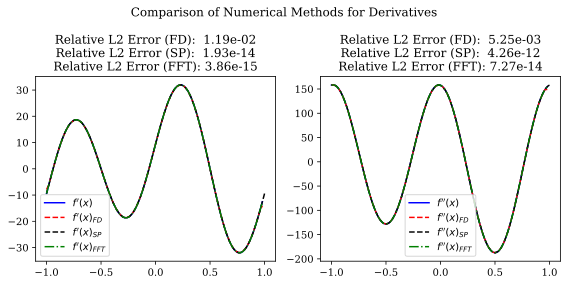

In [9]:
# Number of points
N = 100

## Data
fy = lambda x: 3*np.sin(np.pi*x) - 4*np.cos(2*np.pi*x)

## Finite Difference
x_FD = np.linspace(-1, 1, N, endpoint=False); dx = x_FD[1]-x_FD[0]

D1 = (-np.eye(N, k=-1)               + np.eye(N, k=1))/(2*dx )
D2 = ( np.eye(N, k=-1) - 2*np.eye(N) + np.eye(N, k=1))/(dx**2)

## One-sided Boundary
D1[0,  0] = -1/dx; D1[0,  1] =  1/dx
D1[-1,-1] =  1/dx; D1[-1,-2] = -1/dx
D2[0,  0] =  1/(dx**2); D2[0,  1] = -2/(dx**2); D2[0,  2] = 1/(dx**2)
D2[-1,-1] =  1/(dx**2); D2[-1,-2] = -2/(dx**2); D2[-1,-3] = 1/(dx**2)

def chebdif(N, M):
    """
    Chebyshev differentiation matrix up to max order M. 
    args:
       `M`: max order of differentiation
       `N`: number of nodes (should be n in our notation)
    return:   
       `D`: numpy array of shape (M,N,N)
    """
    if M >= N: raise Exception('numer of nodes must be greater than M')        
    if M <= 0: raise Exception('derivative order must be at least 1')

    DM = np.zeros((M,N,N))    
    
    n1 = int(np.floor(N/2)); n2 = int(np.ceil(N/2))    # indices used for flipping trick [Corrected]
    k  = np.arange(N)                                   # compute theta vector
    th = k*np.pi/(N-1)    

    # Compute the Chebyshev points
    x = np.sin(np.pi*((N-1)-2*np.linspace(N-1,0,N))/(2*(N-1)))   # W&R way
    x = x[::-1]
    
    # Assemble the differentiation matrices
    T = np.tile(th/2,(N,1))
    DX = 2*np.sin(T.T+T)*np.sin(T.T-T)               # trigonometric identity
    DX[n1:,:] = -np.flipud(np.fliplr(DX[0:n2,:]))    # flipping trick
    DX[range(N),range(N)] = 1.                       # diagonals of D
    DX = DX.T

    C = sp.linalg.toeplitz((-1.)**k)     # matrix with entries c(k)/c(j)
    C[ 0,:] *= 2
    C[-1,:] *= 2
    C[:, 0] *= 0.5
    C[:,-1] *= 0.5

    Z = 1./DX                        # Z contains entries 1/(x(k)-x(j))
    Z[range(N),range(N)] = 0.        # with zeros on the diagonal.          

    D = np.eye(N)                    # D contains differentiation matrices.
    for ell in range(M):
        D = (ell+1)*Z*(C*np.tile(np.diag(D),(N,1)).T - D)  # off-diagonals    
        D[range(N),range(N)] = -np.sum(D,axis=1)           # negative sum trick
        DM[ell,:,:] = D                                    # store current D in DM
    return x, DM

## Spectral Method
x_SP, DM = chebdif(N, 2)

# Compute the wave numbers
k = (np.remainder(0.5 + (np.arange(N))/N, 1.) - 0.5) * (2*np.pi/dx)

## Exact Solution
y_x_FD  =  3*np.pi*   np.cos(np.pi*x_FD) + 8 *np.pi*   np.sin(2*np.pi*x_FD)
y_xx_FD = -3*np.pi**2*np.sin(np.pi*x_FD) + 16*np.pi**2*np.cos(2*np.pi*x_FD)
y_x_SP  =  3*np.pi*   np.cos(np.pi*x_SP) + 8 *np.pi*   np.sin(2*np.pi*x_SP)
y_xx_SP = -3*np.pi**2*np.sin(np.pi*x_SP) + 16*np.pi**2*np.cos(2*np.pi*x_SP)


# Compute exact and numerical derivatives
numerical_y_x_FD = D1 @ fy(x_FD)
numerical_y_xx_FD = D2 @ fy(x_FD)
numerical_y_x_SP  = DM[0] @ fy(x_SP)
numerical_y_xx_SP = DM[1] @ fy(x_SP)
numerical_y_x_FFT  = np.fft.ifft( 1j*k*np.fft.fft(fy(x_FD))).real
numerical_y_xx_FFT = np.fft.ifft(-k**2*np.fft.fft(fy(x_FD))).real

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=100, tight_layout=True)

# Plot for f'(x)
axs[0].plot(x_FD, y_x_FD, 'b-', label=r"$f'(x)$")
axs[0].plot(x_FD, numerical_y_x_FD,  'r--', label=r"$f'(x)_{FD}$")
axs[0].plot(x_SP, numerical_y_x_SP,  'k--', label=r"$f'(x)_{SP}$")
axs[0].plot(x_FD, numerical_y_x_FFT, 'g-.', label=r"$f'(x)_{FFT}$")
axs[0].set_title(
    f"Relative L2 Error (FD):  {np.linalg.norm(numerical_y_x_FD - y_x_FD) / np.linalg.norm(y_x_FD):.2e}\n"
    f"Relative L2 Error (SP):  {np.linalg.norm(numerical_y_x_SP - y_x_SP) / np.linalg.norm(y_x_SP):.2e}\n"
    f"Relative L2 Error (FFT): {np.linalg.norm(numerical_y_x_FFT - y_x_FD) / np.linalg.norm(y_x_FD):.2e}",
    multialignment='center'
)
axs[0].legend()

# Plot for f''(x)
axs[1].plot(x_FD, y_xx_FD, 'b-', label=r"$f''(x)$")
axs[1].plot(x_FD, numerical_y_xx_FD,  'r--', label=r"$f''(x)_{FD}$")
axs[1].plot(x_SP, numerical_y_xx_SP,  'k--', label=r"$f''(x)_{SP}$")
axs[1].plot(x_FD, numerical_y_xx_FFT, 'g-.', label=r"$f''(x)_{FFT}$")
axs[1].set_title(
    f"Relative L2 Error (FD):  {np.linalg.norm(numerical_y_xx_FD - y_xx_FD) / np.linalg.norm(y_xx_FD):.2e}\n"
    f"Relative L2 Error (SP):  {np.linalg.norm(numerical_y_xx_SP - y_xx_SP) / np.linalg.norm(y_xx_SP):.2e}\n"
    f"Relative L2 Error (FFT): {np.linalg.norm(numerical_y_xx_FFT - y_xx_FD) / np.linalg.norm(y_xx_FD):.2e}",
    multialignment='center'
)
axs[1].legend()

plt.suptitle("Comparison of Numerical Methods for Derivatives")

## Differentiation Matrices: Higher Order Derivatives

When computing higher-order derivatives using differentiation matrices, there are two main approaches:

### 1. Matrix Multiplication Method

The simplest approach is to use explicit matrix multiplication. For example:
- Third derivative: $\boldsymbol{D}_3 = \boldsymbol{D}_1 \boldsymbol{D}_2$
- Fourth derivative: $\boldsymbol{D}_4 = \boldsymbol{D}_1 \boldsymbol{D}_3$ or $\boldsymbol{D}_2 \boldsymbol{D}_2$

While this method is straightforward to implement, it has some significant drawbacks:
- Computational complexity of $O(N^3)$
- Potential accumulation of numerical errors
- Less efficient for large matrices

### 2. Recurrence Relations Method

A more efficient approach uses recurrence relations to compute higher-order differentiation matrices directly. This method:
- Reduces computational complexity to $O(N^2)$
- Provides better numerical stability
- Is more memory efficient

The improvement in computational efficiency from $O(N^3)$ to $O(N^2)$ becomes particularly significant when working with:
- Large-scale systems
- Real-time applications
- Problems requiring high-order derivatives

# Integration

## One-Dimensional Integration and Quadrature Rules

For a function $f: \mathbb{R} \rightarrow \mathbb{R}$, the definite integral over the interval $[a, b]$ is given by:
$$
I(f) = \int_a^b f(x) \, dx
$$

An $N$-point quadrature rule approximates this integral using a weighted sum of function values:
$$
I_N(f) = \sum_{i=1}^N w_i f(x_i) = \boldsymbol{w}^\top \boldsymbol{f} = \langle \boldsymbol{w}, \boldsymbol{f} \rangle = E_{\mathbf{w}}[f]
$$
where $\boldsymbol{w}$ is the vector of weights, $\boldsymbol{f}$ is the vector of function values at nodes $x_i$, and $E_{\mathbf{w}}[f]$ denotes the expectation with respect to the weights.

In abstract terms, integration over $[a, b]$ acts as a linear functional $I(f)$ on the space of functions. A numerical approximation like $I_N(f)$, based on sampled data, is also a linear functional. By the Riesz Representation Theorem, any linear functional in a Hilbert space can be represented as an inner product with a specific vector—in this context, the weight vector $\boldsymbol{w}$.

### Newton-Cotes Quadrature (Equally Spaced Grid)

Newton-Cotes quadrature rules utilize function evaluations at **equally spaced** points within the interval.

1. **Midpoint Rule:**

   The midpoint rule divides the interval into $n$ subintervals and evaluates the function at the midpoint of each subinterval. The weights are all equal to the width of the subintervals $\Delta x$:
   $$
   \boldsymbol{w} = [\Delta x, \Delta x, \Delta x, \ldots, \Delta x]
   $$

2. **Trapezoidal Rule:**

   The trapezoidal rule evaluates the function at both endpoints and intermediate points. The weights assign half the width to the endpoints and full width to the interior points:
   $$
   \boldsymbol{w} = \left[ \tfrac{\Delta x}{2}, \Delta x, \Delta x, \ldots, \Delta x, \tfrac{\Delta x}{2} \right]
   $$

3. **Simpson's Rule:**

   Simpson's rule approximates the integral by fitting parabolas through subsets of points (requires an even number of intervals). The weights alternate between $\tfrac{4\Delta x}{3}$ and $\tfrac{2\Delta x}{3}$, with the endpoints weighted by $\tfrac{\Delta x}{3}$:
   $$
   \boldsymbol{w} = \left[ \tfrac{\Delta x}{3}, \tfrac{4\Delta x}{3}, \tfrac{2\Delta x}{3}, \tfrac{4\Delta x}{3}, \ldots, \tfrac{2\Delta x}{3}, \tfrac{4\Delta x}{3}, \tfrac{\Delta x}{3} \right]
   $$

In [10]:
# Define the functions
f1 = lambda x: np.abs(x)**3
f2 = lambda x: np.exp(-x**(-2))
f3 = lambda x: 1 / (1 + x**2)
f4 = lambda x: x**10

functions = [f1, f2, f3, f4]
labels = ['|x|^3', 'exp(-x^{-2})', '1/(1+x^2)', 'x^{10}']

# Define the integration interval and number of points
a, b = -1, 1
n_midpoint = 100
n_trapezoidal = 100
n_simpson = 100  # Note: Simpson's Rule requires an even number of intervals


x_midpoint = np.linspace(a+(b-a)/(2*n_midpoint), b-(b-a)/(2*n_midpoint), n_midpoint)
w_midpoint = np.full(n_midpoint, (b-a)/n_midpoint)

x_trapezoidal = np.linspace(a, b, n_trapezoidal + 1)
w_trapezoidal = np.full(n_trapezoidal + 1, (b-a)/n_trapezoidal)
w_trapezoidal[0] /= 2  # Adjusting weight for the first and last points
w_trapezoidal[-1] /= 2

x_simpson = np.linspace(a, b, n_simpson+1)
w_simpson = np.zeros(n_simpson+1)
w_simpson[0] = w_simpson[-1] = (b-a)/(3*n_simpson)
for i in range(1, n_simpson):
    if i % 2 == 0:
        w_simpson[i] = 2*(b-a)/(3*n_simpson)
    else:
        w_simpson[i] = 4*(b-a)/(3*n_simpson)


for f, label in zip(functions, labels):
    print(f"For {label}:")
    print(f"Midpoint rule:    {w_midpoint.T    @ f(x_midpoint   )}")
    print(f"Trapezoidal rule: {w_trapezoidal.T @ f(x_trapezoidal)}")
    print(f"Simpson's rule:   {w_simpson.T     @ f(x_simpson    )}")
    print()

For |x|^3:
Midpoint rule:    0.4999
Trapezoidal rule: 0.5002
Simpson's rule:   0.49999999999999994

For exp(-x^{-2}):
Midpoint rule:    0.1781231859137205
Trapezoidal rule: 0.178196763027214
Simpson's rule:   0.1781477091757449

For 1/(1+x^2):
Midpoint rule:    1.5708129934615014
Trapezoidal rule: 1.570762993461627
Simpson's rule:   1.5707963267936274

For x^{10}:
Midpoint rule:    0.18148512836087388
Trapezoidal rule: 0.18248452861282294
Simpson's rule:   0.18181945926033172



/var/folders/wg/4qh4wrxs07527dd791lnfmmh0000gn/T/ipykernel_9023/4186003396.py:3: RuntimeWarning: divide by zero encountered in power
  f2 = lambda x: np.exp(-x**(-2))


### Integrating Definite Integrals via ODEs

Computing a definite integral of the form
$$
I(x) = \int_a^x f(u) \, du
$$
can be transformed into solving an initial value problem (IVP) for an ordinary differential equation (ODE). According to the Fundamental Theorem of Calculus, differentiating both sides with respect to $ x $ yields:
$$
\frac{dI(x)}{dx} = f(x), \quad \text{with} \quad I(a) = 0.
$$
This reveals that $ I(x) $ satisfies a simple first-order ODE with a known initial condition at $ x = a $.

To approximate the integral numerically, we can apply numerical ODE solvers such as Runge-Kutta methods. For instance, using the classical fourth-order Runge-Kutta method to solve this ODE provides an estimate of $ I(x) $. While Runge-Kutta methods are primarily designed for solving ODEs, their application here allows us to leverage their accuracy for numerical integration.

**Note:** This approach connects numerical integration with ODE solvers, offering an alternative to traditional quadrature methods and potentially achieving higher accuracy.

### Spectral Quadrature Methods (Using Unequally Spaced Grids)

Spectral quadrature methods employ **unequally spaced** nodes, often corresponding to the roots or extrema of orthogonal polynomials like Chebyshev polynomials. These methods can achieve high accuracy with relatively few nodes due to their spectral (exponential) convergence properties.

#### An Initial Spectral Method (Not the Optimal Approach)

Let's consider constructing a spectral method on the interval $ [-1, 1] $ using Chebyshev nodes. To enforce the boundary condition $ I(-1) = 0 $, we modify the spectral differentiation matrix $ D $ by removing the last row and column associated with the boundary condition. This yields a reduced matrix $ \widetilde{D} $ of size $ N \times N $.

The discretized ODE $ \frac{dI}{dx} = f(x) $ becomes a linear system:
$$
\widetilde{D} \, \mathbf{v} = \mathbf{f},
$$
where $ \mathbf{v} $ approximates the integral values at the nodes, and $ \mathbf{f} $ contains the function values $ f(x_j) $. Our approximation to the definite integral up to $ x_0 $ (the first node) is then $ I_N = v_0 $.

Since we're primarily interested in $ v_0 $, we can compute it directly without solving the entire system. Let $ \mathbf{w}^\top $ denote the first row of $ \widetilde{D}^{-1} $, a vector of weights of length $ N $. The integral approximation is given by:
$$
I_N = \mathbf{w}^\top \mathbf{f}.
$$

#### Clenshaw-Curtis Quadrature

A more effective approach is the **Clenshaw-Curtis quadrature**, which utilizes the Chebyshev nodes differently. The key steps are:

1. **Polynomial Interpolation:**
   Find the interpolating polynomial $ p(x) $ of degree $ \leq N $ such that:
   $$
   p(x_j) = f_j, \quad \text{for} \quad 0 \leq j \leq N,
   $$
   where $ x_j $ are the Chebyshev nodes and $ f_j = f(x_j) $.

2. **Exact Integration of the Polynomial:**
   Compute the approximate integral by integrating the interpolating polynomial:
   $$
   I_N = \int_{-1}^1 p(x) \, dx.
   $$

This method differs from the previous one by including all nodes, especially the endpoints, leading to higher accuracy. It integrates polynomials of degree up to $ N $ exactly (instead of $ N + 1 $ in the prior method) because it incorporates the function value at $ x = -1 $, which was ignored before.

The Clenshaw-Curtis quadrature is renowned for its efficiency and precision. It often rivals Gaussian quadrature in accuracy but offers easier implementation, particularly due to the utilization of the Fast Fourier Transform (FFT) algorithms for computing the weights.

In [11]:
def clencurt(N):
    """
    Compute the Clenshaw-Curtis nodes and weights for numerical integration.
    
    Parameters:
    N (int): Number of intervals
    
    Returns:
    x (ndarray): Clenshaw-Curtis nodes
    w (ndarray): Clenshaw-Curtis weights
    """
    theta = np.pi * np.arange(N + 1) / N
    x = np.cos(theta)
    w = np.zeros(N + 1)
    ii = np.arange(1, N)
    v = np.ones(N - 1)
    
    if N % 2 == 0:
        w[0] = 1 / (N**2 - 1)
        w[N] = w[0]
        for k in range(1, N // 2):
            v -= 2 * np.cos(2 * k * theta[ii]) / (4 * k**2 - 1)
        v -= np.cos(N * theta[ii]) / (N**2 - 1)
    else:
        w[0] = 1 / N**2
        w[N] = w[0]
        for k in range(1, (N - 1) // 2 + 1):
            v -= 2 * np.cos(2 * k * theta[ii]) / (4 * k**2 - 1)
    
    w[ii] = 2 * v / N
    return x, w

# Define the functions to integrate
f1 = lambda x: np.abs(x)**3
f2 = lambda x: np.exp(-x**(-2))
f3 = lambda x: 1 / (1 + x**2)
f4 = lambda x: x**10

functions = [f1, f2, f3, f4]
labels = ['|x|^3', 'exp(-x^{-2})', '1/(1+x^2)', 'x^{10}']

# Number of intervals
N = 100

# Compute Clenshaw-Curtis nodes and weights
x, w = clencurt(N)

# Compute and print the integral for each function
for f, label in zip(functions, labels):
    integral = w.T @ f(x)
    print(f"For {label}:")
    print(f"Integral: {integral}")
    print()

For |x|^3:
Integral: 0.5000000162427916

For exp(-x^{-2}):
Integral: 0.1781477117815619

For 1/(1+x^2):
Integral: 1.570796326794897

For x^{10}:
Integral: 0.1818181818181818



#### Gaussian Quadrature

While Clenshaw-Curtis quadrature exhibits excellent convergence rates due to its spectral accuracy, there is room for improvement. **Gaussian quadrature** pushes this accuracy further by making the integral exact for polynomials of degree up to $2N - 1$, compared to $N$ or $N - 1$ for Clenshaw-Curtis quadrature.

To achieve this higher degree of exactness, we select the nodes $\{ x_j \}$ to be the roots of **Legendre polynomials** over the interval $(-1, 1)$, rather than using Chebyshev points. These Legendre nodes and their associated weights can be determined numerically by solving an eigenvalue problem involving a tridiagonal matrix derived from the recurrence relations of Legendre polynomials.

Gaussian quadrature offers significant advantages for evaluating definite integrals due to its superior accuracy. However, in the context of spectral methods for solving differential equations—which is often the primary application—Gaussian quadrature is most beneficial when employing a **Galerkin formulation**. In Galerkin methods, the test functions (weight functions) are chosen from the same space as the trial functions, making Gaussian quadrature a natural fit.

In contrast, for **collocation methods**, where the solution is enforced at specific discrete points, Gaussian quadrature is less relevant. Collocation methods typically prioritize computational efficiency and simplicity over the maximal degree of exactness in integration.

**Note:** The choice between Galerkin and collocation formulations can depend on the specific problem and practitioner preference. Some experts advocate for Galerkin methods due to their theoretical advantages and potential for higher accuracy. Others prefer collocation methods, arguing that the increased complexity and computational effort of Galerkin methods may not yield substantial benefits for certain applications.

In [12]:
# Define the functions to integrate
f1 = lambda x: np.abs(x)**3
f2 = lambda x: np.exp(-x**(-2))
f3 = lambda x: 1 / (1 + x**2)
f4 = lambda x: x**10

functions = [f1, f2, f3, f4]
labels = ['|x|^3', 'exp(-x^{-2})', '1/(1+x^2)', 'x^{10}']

# Number of points
N = 100

# Compute nodes and weights
x, w = roots_legendre(N)

# Compute and print the integral for each function
for f, label in zip(functions, labels):
    print(f"For {label}:")
    print(f"Integral: {w.T @ f(x)}")
    print()

For |x|^3:
Integral: 0.49999998606859863

For exp(-x^{-2}):
Integral: 0.17814771178155403

For 1/(1+x^2):
Integral: 1.570796326794902

For x^{10}:
Integral: 0.18181818181816267



#### Integration using scipy

The `scipy` library provides a function `quad` that can be used to perform numerical integration. The function `quad` takes the function to be integrated as an argument and returns the integral value and an estimate of the absolute error. It also has `dblquad` and `tplquad` functions for double and triple integrals.

In [13]:
# Define the functions
f1 = lambda x: np.abs(x)**3
f2 = lambda x: np.exp(-x**(-2)) if x != 0 else 0  # Handle x=0 case
f3 = lambda x: 1 / (1 + x**2)
f4 = lambda x: x**10

functions = [f1, f2, f3, f4]
labels = ['|x|^3', 'exp(-x^{-2})', '1/(1+x^2)', 'x^{10}']

# Define the integration limits
a, b = -1, 1  # Change these as needed

for f, label in zip(functions, labels):
    integral, error = quad(f, a, b)
    print(f"For {label}:")
    print(f"Integral: {integral}")
    print(f"Estimated error: {error}")
    print()

For |x|^3:
Integral: 0.5
Estimated error: 5.551115123125783e-15

For exp(-x^{-2}):
Integral: 0.1781477117814575
Estimated error: 7.807844983475796e-09

For 1/(1+x^2):
Integral: 1.5707963267948966
Estimated error: 1.7439342485646153e-14

For x^{10}:
Integral: 0.18181818181818185
Estimated error: 2.0185873175002848e-15



#### Composite Quadrature

An alternative to increasing the number of nodes or using higher-degree quadrature rules is to subdivide the original interval into smaller subintervals and apply a simple quadrature rule within each one. By summing the results from all subintervals, we obtain an approximation of the overall integral. This method is known as **composite quadrature** and is equivalent to using piecewise interpolation to derive the quadrature rule.

Composite quadrature rules inherit the stability of the underlying simple quadrature rule. If the basic quadrature rule is stable, then the composite rule is also stable. Moreover, the approximate integral converges to the exact integral as the number of subintervals approaches infinity, provided that the underlying simple rule has at least degree zero (i.e., it accurately integrates constant functions).

#### Adaptive Quadrature

While composite quadrature with uniform subdivision is straightforward, it can be inefficient for integrands with varying behavior. A more sophisticated method is **adaptive quadrature**, where the integration domain is selectively refined based on the characteristics of the integrand. The idea is to subdivide intervals more finely where the integrand exhibits rapid changes or high curvature and less where it is smooth.

Adaptive quadrature is generally effective in practice, but it has limitations. Since the integrand is sampled at only a finite number of points, significant features might be missed, leading to incorrect approximations and error estimates. For instance, if the integrand has critical behavior confined to a narrow region within a large interval, an adaptive routine might not sample this region sufficiently, resulting in an inaccurate integral computation.

Additionally, adaptive quadrature can be inefficient when dealing with discontinuities in the integrand. The routine may expend numerous function evaluations attempting to refine the region around a discontinuity. To mitigate this issue, it's advisable to partition the integral at the points of discontinuity and apply the quadrature method separately to each continuous segment. This approach avoids the need to resolve the discontinuity within the adaptive procedure, improving both efficiency and accuracy.

#### Bayesian Quadrature

**Bayesian quadrature** is a probabilistic approach to numerical integration and is part of the field of probabilistic numerics. It frames the computation of integrals as a statistical inference problem. By modeling the integrand as a random function with a prior distribution—typically a **Gaussian Process**—Bayesian quadrature computes the integral as the expected value and quantifies the uncertainty through the posterior variance.

This method provides a comprehensive treatment of uncertainty in the integral estimation, which is particularly valuable when function evaluations are expensive or limited in number. The Gaussian Process framework allows for incorporating prior knowledge about the function, leading to potentially more accurate estimations with fewer samples.

However, a significant limitation of Bayesian quadrature is its computational cost. The method generally requires $\mathcal{O}(N^3)$ computational time, where $N$ is the number of data points (function evaluations). This cubic complexity arises from operations like inverting the covariance matrix inherent in Gaussian Process regression, making Bayesian quadrature computationally intensive for large $N$.

## Multidimensional Integrals 
**Note:** Refer to the "Inference" Notebook for More Details.

The quadrature rules discussed earlier are primarily designed for computing **one-dimensional integrals**. When extending these methods to **multidimensional integrals**, a common approach is to express the multiple integral as nested one-dimensional integrals using Fubini's theorem—this is known as the **tensor product rule**. However, this technique suffers from the **curse of dimensionality**, where the number of required function evaluations grows exponentially with the number of dimensions.

To address this challenge, several methods have been developed that mitigate the curse of dimensionality:

1. **Markov Chain Monte Carlo (MCMC) Methods**: These stochastic methods use random sampling to estimate integrals over high-dimensional spaces. By relying on the law of large numbers and the central limit theorem, MCMC methods provide probabilistic estimates of integrals, making them well-suited for high-dimensional problems.

2. **Quasi-Monte Carlo (QMC) Methods**: QMC methods improve upon traditional Monte Carlo integration by using deterministic, low-discrepancy sequences instead of random samples. These sequences more uniformly cover the integration domain, often leading to faster convergence rates in the estimation of integrals.

3. **Sparse Grid Quadrature Methods**: Sparse grid techniques reduce the number of function evaluations needed for high-dimensional integrals by constructing grids that are sparse in the multidimensional space. By judiciously selecting integration points based on hierarchical bases, sparse grids alleviate the curse of dimensionality more effectively than full tensor product grids.